In [1]:
import random
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from PIL import Image
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
from tqdm.auto import tqdm


In [5]:
%load_ext autoreload
%autoreload 2

from src.model.CNN_regression import (
    DBHDepthDataset,
    DBHRegressor,
    evaluate,
    get_eval_transforms,
    train_one_epoch,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_model(backbone, checkpoint_path, device):
    model = DBHRegressor(backbone)
    state_dict = torch.load(checkpoint_path, map_location=device)

    # handle DataParallel checkpoints
    if any(k.startswith("module.") for k in state_dict.keys()):
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

In [9]:
@torch.no_grad()
def visualize_random_test_samples(
    checkpoint_path: str,
    backbone: str,
    test_csv: str,
    base_path: str,
    k: int = 4,
    image_size: int = 192,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    base_path = Path(base_path)
    df = pd.read_csv(test_csv)

    samples = df.sample(k)

    model = load_model(backbone, checkpoint_path, device)
    model.eval()

    # IMPORTANT: same transforms as eval
    depth_transform = get_eval_transforms(
        image_size=image_size,
        in_channels=1,
    )

    fig, axes = plt.subplots(k, 2, figsize=(10, 2 * k))

    if k == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (_, row) in enumerate(samples.iterrows()):
        rgb_path = base_path / "test" / row["image_path"]
        depth_path = base_path / row["depth_anything_maps_path"]
        gt_dbh = row["DBH"]

        # --- RGB (for visualization only)
        rgb = Image.open(rgb_path).convert("RGB")

        # --- Depth (for model input)
        depth = np.load(depth_path).astype(np.float32)
        depth = np.clip(depth, 0, 255).astype(np.uint8)
        depth_pil = Image.fromarray(depth, mode="L")

        depth_tensor = depth_transform(depth_pil).unsqueeze(0).to(device)

        # predict
        pred_dbh = model(depth_tensor).item()
        pred_dbh = np.expm1(pred_dbh)
        
        # --- plot RGB
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title("RGB Image")
        axes[i, 0].axis("off")

        # --- plot depth
        axes[i, 1].imshow(depth, cmap="gray")
        axes[i, 1].set_title(
            f"Depth Map\nGT: {gt_dbh:.2f} cm | Pred: {pred_dbh:.2f} cm"
        )
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


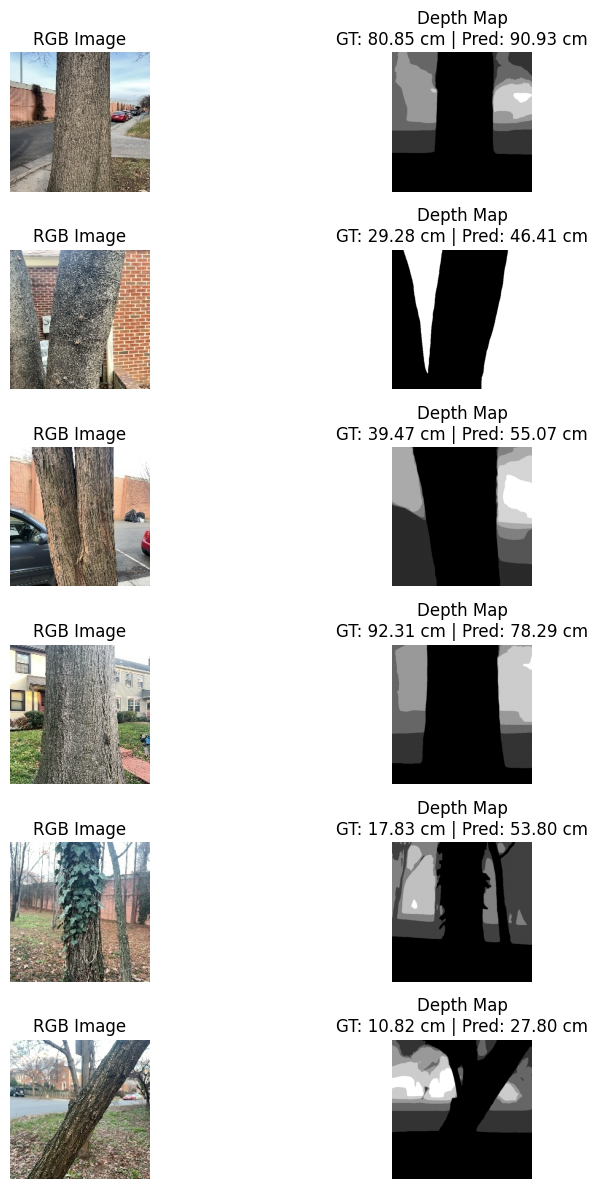

In [13]:
checkpoint = "../model/resnet50_depth_dbh_DA3_LARGE_20260210_0423_38_best.pt"
test_csv = "../dataset/DepthMapDBH2023/test/test/files_with_depth_maps_DA3_LARGE.csv"

visualize_random_test_samples(
    checkpoint_path=checkpoint,
    backbone="resnet50",
    test_csv=test_csv,
    base_path="../dataset/DepthMapDBH2023/",
    k=6,
)